# Clasificación utilizando datasets con clases desproporcionadas

El objetivo es usar un perceptrón simple para clasificar personas sanas/enfermas usando como entrada un dataset con distintas proporciones de mujeres y hombres y analizar de que manera las distintas variaciones en el dataset influyen en las predicciones.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import seaborn as sns
import random
import sys
import csv  
import os

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf

In [ ]:
from google.colab import files
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
from google.colab import drive
drive.mount('drive')
!pip install -U -q PyDrive

Mounted at drive


In [ ]:
# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
# (colab) directory to store the data.
local_download_path = os.path.expanduser('/Datos')
try:
  os.makedirs(local_download_path)
except: pass
# 2. Auto-iterate using the query syntax
file_list = drive.ListFile(
    {'q': "'1YmYJvNXJNDG1Ori_u1rQwM0RPixv1oDf' in parents and trashed=false"}).GetList() 

for f in file_list:
  # 3. Create & download by id.
  print('title: %s, id: %s' % (f['title'], f['id']))
  fname = os.path.join(local_download_path, f['title'])
  print('downloading to {}'.format(fname))
  f_ = drive.CreateFile({'id': f['id']})
  f_.GetContentFile(fname)

title: dataset.csv, id: 1B7eBJ2R2Pj3xdiTiJUcTYsOIy5xupW8v
downloading to /Datos/dataset.csv


In [ ]:
plt.rcParams["figure.figsize"]=(20,10)
sns.set(font_scale = 1.5,context = "notebook", style = "white",  font = "sans-serif",  color_codes = False, rc = None)

**Matriz de varianzas-covarianzas**

Matriz cuadrada que contiene las varianzas y covarianzas asociadas con diferentes variables. Los elementos de la diagonal principal son las varianzas de las variables y los elementos fuera de la diagonal son las covarianzas entre todos los pares posibles de variables.
Es simétrica, porque la covarianza de las variables (i,j) es igual a la de (j,i)

In [ ]:
def mat_cov(p, sigma): #  sigma = [0.3   0.4] 
  var, cov = [0, 0], [0, 0]

  var[0]=sigma[0]*sigma[0]
  var[1]=sigma[1]*sigma[1]

  cov[0]= p*sigma[1]*sigma[0]
  cov[1]= p*sigma[0]*sigma[1]

  m_cov = [[var[0], cov[1]], [cov[0], var[1]]]  # diagonal covariance
  return m_cov

Definiciones de la media y la matriz de covarianza de cada grupo:

In [ ]:
mean = [[1,2],[3,2],[2,1],[4,1]]
m_cov = mat_cov(0, [.4,.4])

**Dataset base:**

Genero patrones en cantidades balanceadas de cada subgrupo para luego armar los datasets.

In [ ]:
x, y =  [0]*4, [0]*4
dt = [[[0 for k in range(3)] for j in range(11)] for i in range(3)]
for k in range(3):
  for j in range(11):
    for i in range(4): 
       x[i], y[i] = np.random.multivariate_normal(mean[i], m_cov, 500).T
    # Movemos las nubes de puntos correspondientes a los datos de hombres s/e para generar nuevos datasets
    x[2] = [i+k for i in x[2]]
    x[3] = [i+k for i in x[3]]
    # Definimos numero de mujeres y de hombres por cada subgrupo
    n_m = j*50
    n_h = round(500 - n_m)
    
    # dt[n_dt_de_ejemplo][porcentaje_mujeres(0-4)][x_y_s]
    dt[k][j] = [np.array([*x[0][0:j*50],*x[1][0:j*50],*x[2][0:n_h],*x[3][0:n_h]]), 
                np.array([*y[0][0:j*50],*y[1][0:j*50],*y[2][0:n_h],*y[3][0:n_h]]), 
                np.array([1]*j*50 + [0]*j*50 + [1]*n_h + [0]*n_h)]
    

**Dataset test:**

Genero patrones en cantidades balanceadas de cada subgrupo para luego testear

In [ ]:
x, y = [0]*4, [0]*4
dt_test = [[0 for k in range(3)] for j in range(3)]
for k in range(3):
    for i in range(4): 
       x[i],y[i] = np.random.multivariate_normal(mean[i], m_cov, 125).T
    x[2] = [i+k for i in x[2]]
    x[3] = [i+k for i in x[3]]
    
    # dt_test[n_dt_de_ejemplo][x_y_s]
    dt_test[k] = [np.array([*x[0],*x[1],*x[2],*x[3]]), 
                  np.array([*y[0],*y[1],*y[2],*y[3]]), 
                  np.array([1]*125 + [0]*125 + [1]*125 + [0]*125)]
                    
  # s_test tiene 3 datasets de test con 500 patrones balanceados c/u

In [ ]:
xy_t = [[0] for j in range(3)]
for i in range(3):
      xy_t[i] = np.array([dt_test[i][0], dt_test[i][1]])

Funciones para graficar

In [ ]:
def _grafica_dataset(k, j, p):
  p_m = j*.10
  p_h = 1 - p_m
  n_m = round((1000*p_m)*.5)
  n_h = round((1000*p_h)*.5)
  p1 = p.plot(dt[k][j][0][0:n_m],dt[k][j][1][0:n_m],'ro', alpha = 0.8)
  p2 = p.plot(dt[k][j][0][n_m:n_m*2],dt[k][j][1][n_m:n_m*2],'rx',alpha = 0.8)
  p3 = p.plot(dt[k][j][0][n_m*2:n_m*2+n_h], dt[k][j][1][n_m*2:n_m*2+n_h],'go',alpha = 0.8)
  p4 = p.plot(dt[k][j][0][n_m*2+n_h:1000],dt[k][j][1][n_m*2+n_h:1000], 'gx',alpha = 0.8)

  p.axis([0,7,0,3])
  if p == plt:
    p.show()

In [ ]:
def grafica_dataset(k, j, p, porcentaje): #p es donde se va a graficar. plt o axs. 
  p_m = j*.10
  p_h = 1 - p_m
  n_m = round((1000*p_m)*.5)
  n_h = round((1000*p_h)*.5)

  mfin = round(n_m*porcentaje)
  hfin = round(n_h*porcentaje)
  nm = int(n_m*porcentaje)
  nh = int(n_h*porcentaje)

  x = np.concatenate([ dt[k][j][0][0:mfin], dt[k][j][0][n_m:(n_m + mfin)], dt[k][j][0][n_m*2:(n_m*2+hfin)], dt[k][j][0][n_m*2+n_h:(n_m*2+n_h + hfin)] ])
  y = np.concatenate([ dt[k][j][1][0:mfin], dt[k][j][1][n_m:(n_m + mfin)], dt[k][j][1][n_m*2:(n_m*2+hfin)], dt[k][j][1][n_m*2+n_h:(n_m*2+n_h + hfin)] ])
  sex = np.concatenate([ np.asarray(['m']*nm), np.asarray(['m']*nm), np.asarray(['h']*nh), np.asarray(['h']*nh)  ])
  healty = np.concatenate([ np.asarray(['s']*nm), np.asarray(['e']*nm), np.asarray(['s']*nh), np.asarray(['e']*nh)  ])
  
  cmap = sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True)
  data = {'x':x, 'y':y, 'sex':sex, 'healty':healty}
  df = pd.DataFrame(data)  
  m = {"e": "X", "s": "o"}
  e=sns.scatterplot(data=df, x='x', y='y', alpha=0.6,ax=p,palette='Set2',hue='sex',style='healty', markers=m, legend=False, s=100)
  e.axis([0,7,-.5,3.5])
  e.set(xticks=[0,3.5,7],  yticks=[-0.5,3.5])
   
  

Gráfica de los datasets generados

In [ ]:
#for i in range(3): 
# for j in range(11): 
#    _grafica_dataset(i,j,plt)

Creamos los clasificadores simples para entrenar con los datasets

In [ ]:
def gen_perceptron(k, j):
  indx = np.arange(0,1000)
  random.shuffle(indx)
  #perc = Perceptron(tol=1e-3, max_iter=250)
  perc = SGDClassifier(loss='hinge',tol=1e-3, max_iter=250,)
  #perc = SGDClassifier(loss='log',tol=1e-3, max_iter=250)
  #acomodamos las xy 
  xy = np.array([dt[k][j][0], dt[k][j][1]])
 
  perc.fit(xy.T[:,0:2][indx], dt[k][j][2][indx])
  score = perc.score(xy_t[k].T[:,0:2], dt_test[k][2])
  

  return perc, score

In [ ]:
perc, score = [[ [0] for j in range(11)] for i in range(3)],  [[ [0] for j in range(11)] for i in range(3)]
for i in range(3):
  print('caso ', i)
  for j in range(11):
    perc[i][j], score[i][j]  = gen_perceptron(i, j)
    print('test accuracy:', score[i][j])
 

caso  0
test accuracy: 0.88
test accuracy: 0.976
test accuracy: 0.958
test accuracy: 0.962
test accuracy: 0.974
test accuracy: 0.958
test accuracy: 0.978
test accuracy: 0.962
test accuracy: 0.968
test accuracy: 0.954
test accuracy: 0.862
caso  1
test accuracy: 0.742
test accuracy: 0.856
test accuracy: 0.88
test accuracy: 0.894
test accuracy: 0.894
test accuracy: 0.922
test accuracy: 0.924
test accuracy: 0.92
test accuracy: 0.924
test accuracy: 0.818
test accuracy: 0.746
caso  2
test accuracy: 0.742
test accuracy: 0.746
test accuracy: 0.828
test accuracy: 0.822
test accuracy: 0.818
test accuracy: 0.722
test accuracy: 0.796
test accuracy: 0.814
test accuracy: 0.806
test accuracy: 0.742
test accuracy: 0.744


Función de la recta obtenida de haber entrenado el perceptrón

In [ ]:
def _grafica_recta_pred(perceptron, k, j, p):
 
  x = np.linspace(0,7,50)
  w = perceptron.coef_[0]
  bias = perceptron.intercept_
  y = -(w[0]/w[1]) * x - bias/w[1]

  p.axis([0,7,-.5,3.5])
  p.plot(x, y, color='r')

  _grafica_dataset(k, j, p)
  
 

In [ ]:
def grafica_recta_pred(perceptron, k, j, p):
  x = np.linspace(0,7,50)
  w = perceptron.coef_[0]
  bias = perceptron.intercept_
  y = -(w[0]/w[1]) * x - bias/w[1]
  p.plot(x, y, color='r')   
  grafica_dataset(k, j, p, 0.2)
  
  p.axis([0,7,-.5,3.5])
 
  if p == plt:
    p.show()

Grafica de la clasificación generada

In [ ]:
#for i in range(3):
#  for j in range(11):
#   _grafica_recta_pred(perc[i][j], i, j, plt)


#  Calculo del accuracy de cada subgrupo

zoomeamos:

In [ ]:
plt.rcParams["figure.figsize"]=(40,40*0.27)

In [ ]:
  def acc(k, j): 
     
    score = [0]*3
    score[0] = perc[k][j].score(xy_t[k].T[0:250], dt_test[k][2][0:250])
    score[1] = perc[k][j].score(xy_t[k].T[250:500], dt_test[k][2][250:500])
    score[2] = perc[k][j].score(xy_t[k].T, dt_test[k][2])
    return score

In [ ]:
accur = [[[ 0 for k in range(3)] for j in range(11)] for i in range(3)]
 
for k in range(3):
  for j in range(11): 
    accur[k][j] = acc(k,j)   


In [ ]:
acc_mujeres = [[ 0 for j in range(11)] for i in range(3)]
acc_varones = [[ 0 for j in range(11)] for i in range(3)]
acc_total =   [[ 0 for j in range(11)] for i in range(3)]
 
for j in range(3):
  for i in range(11): 
    acc_mujeres[j][i] = accur[j][i][0] 
    acc_varones[j][i] = accur[j][i][1]
    acc_total[j][i] = accur[j][i][2] 

In [ ]:
def grafica_acc(i, p,acc_m,acc_v,acc_t):
  x = [0,.1,.2,.3,.4,.5,.6,.7,.8,.9, 1]
  p.plot(x, acc_m[i],'ro-',x,acc_v[i],'go-',x,acc_t[i],'mo-')
  if p == plt:
    p.show()

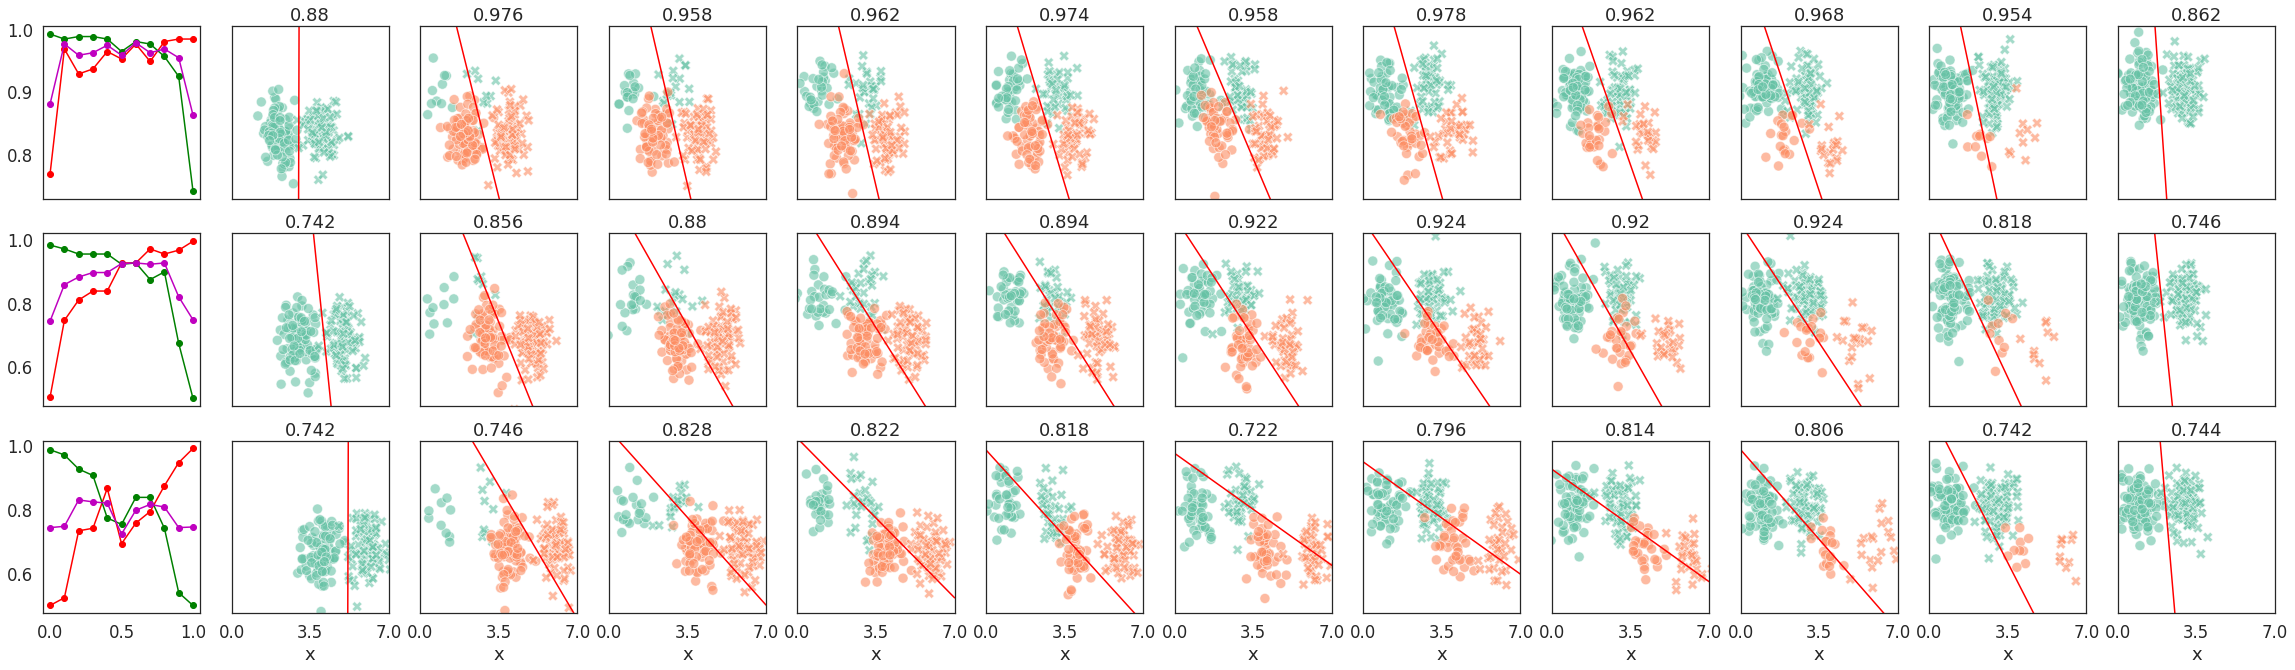

In [ ]:
fig, axs = plt.subplots(3,12)
 
for i in range(3):
  grafica_acc(i, axs[i,0],acc_mujeres,acc_varones,acc_total)
  
    

for i in range(3):
  for j in range(11):
    grafica_recta_pred(perc[i][j], i, j, axs[i,j+1])
    axs[i,j+1].set_title(score[i][j]) 
    

 
# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()
#‘hinge’, ‘log’ 
#pdf o svg no PNG
#fig.savefig('graf_sgd_percep.png', dpi=100)
#files.download('graf_sgd_percep.png') 

# Importar los valores obtenidos a un nuevo archivo

Abrir la carpeta donde estan las accuracy de m v t y descargar los archivos localmente para poder editarlos desde colab

In [ ]:

def graf_acc_p_m(ax, case):
  datos = sns.load_dataset('dataset', data_home='/Datos/') #'p_mujeres','accuracy','sex','case'
  sns.axes_style(style='ticks')
  da=datos.loc[datos['case']==case]
  g = sns.lineplot(x="p_mujeres", y="accuracy",hue="sex", style="sex", data=da, ax= ax)
  g.axis([0,1,0.5,1])
  g.set(xticks=[0,.5,1],  yticks=[0.5,1] )
  g.set_ylabel('accuracy')
  g.set_xlabel('fM') 

In [ ]:
plt.rcParams["figure.figsize"]=(5,16)

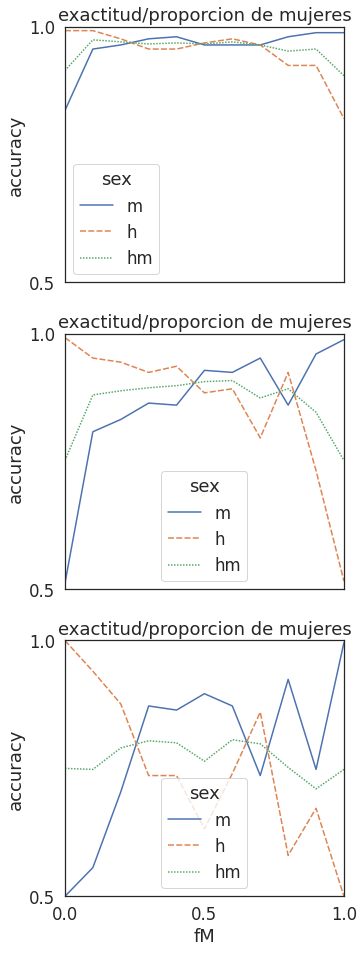

In [ ]:
fig1, axs = plt.subplots(3,1)
 
for i in range(3):
  graf_acc_p_m(axs[i], i)
  axs[i].set_title("exactitud/proporcion de mujeres") 
  
for ax in axs.flat:
    ax.label_outer() 

In [ ]:
#lt.rcParams["figure.figsize"]=(20,16)
#fig2, axs = plt.subplots(3,3)

#for i in range(3):
#  grafica_recta_pred(perc[i][0], i, 0, axs[i,0])
 
#  grafica_recta_pred(perc[i][5], i, 5, axs[i,1])
  
#  grafica_recta_pred(perc[i][10], i, 10, axs[i,2])
   
#for ax in axs.flat:
#    ax.label_outer()
    

In [ ]:
fig1.savefig('g_1.pdf')
from google.colab import drive
drive.mount('drive')
!cp g_1.pdf 'drive/My Drive/Colab Notebooks/version2/'

In [ ]:
def from_file(filename): 
  data = pd.read_csv(filename, dtype=None)
  return data

def to_file(filename, data):
  df = pd.DataFrame(data)
  df.to_csv(filename)


In [ ]:
# % female, acc, label 'm'/'h'/'hm', model
 fem_percent = np.asarray([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]*9)
 
 m = np.asarray(acc_mujeres).T
 h = np.asarray(acc_varones).T
 t = np.asarray(acc_total).T
 acc = np.concatenate([m[:,0], h[:,0], t[:,0], m[:,1], h[:,1], t[:,1], m[:,2], h[:,2], t[:,2]])
 a = np.asarray(['m']*11)
 b = np.asarray(['h']*11)
 c = np.asarray(['hm']*11)
 
 gender = np.concatenate([a,b,c,a,b,c,a,b,c])
 model = np.concatenate([[0]*33,[1]*33,[2]*33])
 print(model)
 dataset = np.asarray([fem_percent, acc, gender, model]).T
 df = pd.DataFrame(dataset,  columns=['p_mujeres','accuracy','sex','case'])
 print(df)

In [ ]:
# df.to_csv('/Datos/dataset_n.csv')
 #data = from_file('/Datos/dataset.csv')
 #dat = data['accuracy'].to_numpy() 
 #dat2= (df['accuracy'].to_numpy())
 #da =( dat + dat2.astype(np.float))*.5
 #df['accuracy'] = da

In [ ]:
df1 = data.loc[:,['p_mujeres','accuracy','sex','case']]

frames = [df1, df]

result = pd.concat(frames)
print(result)

In [ ]:
 #to_file('/Datos/dataset.csv', result)

In [ ]:
 #!cp /Datos/dataset.csv "drive/My Drive/Colab Notebooks/version2/data/"
